# POP Tracer Budget

An integral form of a tracer $c \mid \,c \in \{\theta, S\} $ can be written as:

$$
\mathcal{V} \frac{\partial c}{\partial t} = Q_{adv} + Q_{diff} + Q_{srf\_flx} + Q_{resid}
$$


In [1]:
import os 
import xarray as xr
import numpy as np
from dask.diagnostics import ProgressBar
from glob import glob
%matplotlib inline 

In [2]:
TRACER = "TEMP"
COMPSET = "BRCP85C5CNBDRD"
COMPSET = "B20TRC5CNBDRD"
dir_lens = "/chuva/db2/CESM-LENS/fully_coupled/mon/pop/"
ens_member = 4
ens_str = "{:0>3d}".format(ens_member)
file_tracer = glob(dir_lens + TRACER + "/" + COMPSET + "/b.e11."+ COMPSET +".f09_g16."+ens_str+".pop.h."+TRACER+"*.nc")[0]
ds_tracer = xr.open_dataset(file_tracer,decode_times=False,mask_and_scale=True,chunks={'time': 60})
dz = ds_tracer['dz'];
tarea = ds_tracer['TAREA']
kmt = ds_tracer['KMT']
temp = ds_tracer[TRACER]

In [3]:
def tracer_budget_vol3d (tarea, dz, kmt):
    """
    Arguments: cell area, cell height, max vertical indx
    Returns global 3D volume DataArray: vold3(nz,ny,nx) dtype=float64
    NOTE: does not include SSH variations
    """
    vol3d = (dz*tarea.astype('float64')).load()
    for i in range(dz.shape[0]):
        vol3d[i,:,:] = vol3d[i].where(kmt > i)
    vol3d.attrs = {'units' : 'cm3', 'long_name' : 'Tcell volume'}
    vol3d = vol3d.drop(('ULAT','ULONG'))
    vol3d.name = "vol3d"
    return vol3d

def tracer_budget_mask2d (region_mask, sel_area = 0):
    """
    Return surface mask: if ocean than 1 else nan
    """
    mask = region_mask
    mask = mask.where(region_mask != sel_area,np.nan)
    return (mask/mask)

def tracer_budget_mask3d (var3d):
    """
    Return volume mask: if ocean than 1 else nan
    """
    mask3d = var3d/var3d
    mask3d.attrs = {'units' : '1 / np.nan', 'long_name' : 'mask3d'}
    return mask3d.where(mask3d != 0.,np.nan)

mask3d = tracer_budget_mask3d(temp[0])
vol3d = tracer_budget_vol3d(tarea,dz,kmt)
mask2d = tracer_budget_mask2d(ds_tracer['REGION_MASK'])
area2d = tarea*mask2d

In [4]:
def tracer_budget_var3d_zint_map (tracer, vol3d, klo=0, khi=59):
    """
    Arguments: var4d tracer(t,z,y,x), vol3d cell volume, klo : lowest k index, khi : highest k index
    Returns a 2d tracer map vertical integrated
    !checked!
    """
    units = tracer.units + " cm^3"
    description = "Int_V {" + tracer.name + "} dV"
    long_name = tracer.name + " vertical average"
    attr = {"long_name" : long_name, "units" : units, "description": description, \
            "k_range" : str(klo)+" - "+str(khi)}
    var = tracer.isel(z_t=slice(klo,khi)) * vol3d.isel(z_t=slice(klo,khi))
    var_zint_map = var.sum(dim='z_t')
    var_zint_map = var_zint_map.where(var_zint_map != 0.)
    var_zint_map.attrs = attr
    var_zint_map.name = tracer.name + "_zint" 
    var_zint_map = var_zint_map.drop(("ULONG","ULAT"))
    return var_zint_map

temp_zint_map = tracer_budget_var3d_zint_map (temp,vol3d)

In [5]:
def tracer_budget_tend_appr (TRACER, time_bnd, var_zint):
    """
    Computes approximate TRACER budget tendency given vertically-integrated POP
    TRACER based on differencing successive monthly means
    NOTE: Assumes monthly POP output with timestamp at end-of-month
          rather than mid-month; assumes time has dimension "days".
    """
    secperday = 60.*60*24
    # days in each month * sec/day 
    dt = (time_bnd.isel(d2=1) - time_bnd.isel(d2=0))*secperday
    vfill_value = np.ones(var_zint[0].shape)*np.nan
    
    units = var_zint.units + '/s'
    long_name = var_zint.long_name + ' tendency'
    attr = {'long_name' : long_name, 'units' : units}
    
    # apprx to end of month 
    # X = [X_t + X_(t+1)]/2 
    X = (var_zint + var_zint.shift(time=-1))*0.5
    
    # X = X_t - X_(t-1)
    dX = X - X.shift(time=1)
    
    #units per seconds
    var_zint_tend = dX/dt
    var_zint_tend.attrs = attr
    var_zint_tend.name = TRACER.lower() + "_tend"
    return var_zint_tend

#temp_tend = tracer_budget_tend_appr(ds_tracer['time'],ds_tracer['time_bound'],temp_zint_map)

In [6]:
def tracer_budget_lat_adv_resolved (TRACER, vol3d, COMPSET="B20TRC5CNBDRD", ens_member=4, klo=0, khi=25, tlo=912, thi=1032):
    """
    compute tracer lateral advection integral 
    based on tracer_budget_adv.ncl
    """
    ens_str = "{:0>3d}".format(ens_member)
    dir_budget = "/chuva/db2/CESM-LENS/download/budget/"
    
    if TRACER == "TEMP":
        var_name1 = "UET"
        var_name2 = "VNT"
        units = "degC cm^3/s"
    else:
        var_name1 = "UES"
        var_name2 = "VNS"
        units = "PSU cm^3/s"
        
    f1 = glob(dir_budget+var_name1+"/b.e11."+COMPSET+".f09_g16."+ens_str+".pop.h."+var_name1+"*.nc")[0]
    f2 = glob(dir_budget+var_name2+"/b.e11."+COMPSET+".f09_g16."+ens_str+".pop.h."+var_name2+"*.nc")[0]
    
    long_name = "lateral advective flux (resolved)"
    description = "Int_z{-Div[<"+var_name1+">, <"+var_name2+">]}"
    attr = {'long_name' : long_name, 'units' : units, 'description' : description}
    
    # read tracer associate variable
    ds1 = xr.open_dataset(f1,decode_times=False,mask_and_scale=True,chunks={'time': 60})
    ds2 = xr.open_dataset(f2,decode_times=False,mask_and_scale=True,chunks={'time': 60})
    u_e = (ds1[var_name1]).isel(z_t=slice(klo,khi),time=slice(tlo,thi))
    v_n = (ds2[var_name2]).isel(z_t=slice(klo,khi),time=slice(tlo,thi))
    # shift vol3d
    vol_c = vol3d.isel(z_t=slice(klo,khi))
    vol_w = vol3d.shift(nlon=1).isel(z_t=slice(klo,khi))
    vol_s = vol3d.shift(nlat=1).isel(z_t=slice(klo,khi))
    # shift:
    u_w = u_e.shift(nlon=1)
    v_s = v_n.shift(nlat=1)
    # e.g.: degC cm^3/s
    var1 = u_e*vol_c
    var2 = u_w*vol_w
    var3 = v_n*vol_c
    var4 = v_s*vol_s
    # Div [du/dx + du/dy]
    var5 = (var2-var1) + (var4-var3)
    # vertical integration
    var_lat_adv_res_map = var5.sum(dim='z_t')
    var_lat_adv_res_map.attrs = attr
    var_lat_adv_res_map.name = TRACER.lower() + "_lat_adv_res"
    var_lat_adv_res_map = var_lat_adv_res_map.drop(("ULONG","ULAT"))
    return var_lat_adv_res_map.where(var_lat_adv_res_map != 0.)

temp_lat_adv_res = tracer_budget_lat_adv_resolved(TRACER,vol3d)

In [7]:
def tracer_budget_vert_adv_resolved (TRACER, vol3d, COMPSET="B20TRC5CNBDRD", ens_member=4, klo=1, khi=25, tlo=912, thi=1032):
    """
    tracer vertical advection integral
    Obs. klo==0 -> wtt=0. => klo=1; khi => khi+1 (max:=59)
    """
    ens_str = "{:0>3d}".format(ens_member)
    dir_budget = "/chuva/db2/CESM-LENS/download/budget/"
    
    if TRACER == "TEMP":
        var_name = "WTT"
        units = "degC cm^3/s"
    else:
        var_name = "WTS"
        units = "PSU cm^3/s"
    
    long_name = "vertical advective flux (resolved)"
    description = "Int_z{-d[<"+var_name+">]/dz}"
    attr = {"long_name" : long_name, "units" : units, "description" : description}
    # read tracer associate variable
    f1 = glob(dir_budget+var_name+"/b.e11."+COMPSET+".f09_g16."+ens_str+".pop.h."+var_name+"*.nc")[0]
    ds1 = xr.open_dataset(f1,decode_times=False,mask_and_scale=True,chunks={"time": 60})
    wt = ds1[var_name].isel(time=slice(tlo,thi))
    vol3d = vol3d.rename({'z_t' : 'z_w_top'})
    # e.g. degC cm^3/s
    var1 = wt.isel(z_w_top=klo)*vol3d.isel(z_w_top=klo)
    var2 = wt.isel(z_w_top=khi+1)*vol3d.isel(z_w_top=khi+1)
    var2 = var2.where(~np.isnan(var2),0.)
    var_vert_adv_res_map = (var2 - var1)
    var_vert_adv_res_map.attrs = attr
    var_vert_adv_res_map.name = TRACER.lower()+"_vert_adv_res"
    var_vert_adv_res_map = var_vert_adv_res_map.drop(("ULONG","ULAT"))
    return var_vert_adv_res_map

temp_vert_adv_res = tracer_budget_vert_adv_resolved(TRACER,vol3d)

In [8]:
def tracer_budget_hmix (TRACER, vol3d, COMPSET="B20TRC5CNBDRD", ens_member=4, klo=0, khi=25, tlo=912, thi=1032):
    """
    tracer horizontal mixing
    compute tracer hmix integrals from Horiz Diffusive Fluxes
    vertical fluxes are positive up
    """
    ens_str = "{:0>3d}".format(ens_member)
    dir_budget = "/chuva/db2/CESM-LENS/download/budget/"
    
    if TRACER == "TEMP":
        units = "degC cm^3/s"
    else:
        units = "PSU cm^3/s"
    #diffusive flux variable names
    var_name1 = "HDIFE_"+TRACER
    var_name2 = "HDIFN_"+TRACER
    
    long_name = "lateral diffusive flux (resolved)"
    description = "Int_z{-Div[<"+var_name1+">, <"+var_name2+">]}"
    attr = {"long_name" : long_name, "units" : units, "description" : description}
    
    # read tracer associate variable
    f1 = glob(dir_budget+var_name1+"/b.e11."+COMPSET+".f09_g16."+ens_str+".pop.h."+var_name1+"*.nc")[0]
    f2 = glob(dir_budget+var_name2+"/b.e11."+COMPSET+".f09_g16."+ens_str+".pop.h."+var_name2+"*.nc")[0]
    
    ds1 = xr.open_dataset(f1,decode_times=False,mask_and_scale=True,chunks={"time": 60})
    ds2 = xr.open_dataset(f2,decode_times=False,mask_and_scale=True,chunks={"time": 60})
    u_e = (ds1[var_name1]).isel(z_t=slice(klo,khi),time=slice(tlo,thi))
    v_n = (ds2[var_name2]).isel(z_t=slice(klo,khi),time=slice(tlo,thi))
    
    # shift vol3d
    vol_c = vol3d.isel(z_t=slice(klo,khi))
    vol_w = vol3d.roll(nlon=1,roll_coords=False).isel(z_t=slice(klo,khi))
    vol_s = vol3d.roll(nlat=1,roll_coords=False).isel(z_t=slice(klo,khi))
    
    # shift
    u_w = u_e.roll(nlon=1,roll_coords=False)
    v_s = v_n.roll(nlat=1,roll_coords=False)
    
    # e.g.: degC cm^3/s
    var1 = u_e*vol_c
    var2 = u_w*vol_w
    var3 = v_n*vol_c
    var4 = v_s*vol_s
    # Div []
    var5 = (var2-var1) + (var4-var3)
    #var5 = (var1 - var2) + (var3-var4)
    # copy coordinates
    var5 = var5.assign_coords(TLAT=u_e.coords.get("TLAT"))
    # vertical integration
    var_lat_mix_res_map = var5.sum(dim="z_t")
    var_lat_mix_res_map.attrs = attr
    var_lat_mix_res_map.name = TRACER.lower() + "_lat_mix_res"
    var_lat_mix_res_map = var_lat_mix_res_map.drop(("ULONG","ULAT"))
    return var_lat_mix_res_map.where(var_lat_mix_res_map != 0.)

temp_lat_mix = tracer_budget_hmix(TRACER, vol3d)

In [9]:
def tracer_budget_dia_vmix (TRACER, tarea, kmt, klo=0, khi=25, COMPSET="B20TRC5CNBDRD", ens_member=4, tlo=912, thi=1032):
    """
    Computes vertical integral of diabatic vertical mixing (DIA_IMPVF_), ie. KPP
    """
    ens_str = "{:0>3d}".format(ens_member)
    dir_budget = "/chuva/db2/CESM-LENS/download/budget/"
    
    if TRACER == "TEMP":
        units = "degC cm^3/s"
    else:
        units = "PSU cm^3/s"
    #variable name
    var_name = "DIA_IMPVF_"+TRACER
    
    long_name = "vertical (diabatic) mixing flux (resolved)"
    description = "Int_z{-d[<"+var_name+">]/dz}" 
    attr = {"long_name" : long_name, "units" : units, "description" : description}
    
    # read tracer associate variable
    f1 = glob(dir_budget+var_name+"/b.e11."+COMPSET+".f09_g16."+ens_str+".pop.h."+var_name+"*.nc")[0]
    ds1 = xr.open_dataset(f1,decode_times=False,mask_and_scale=True,chunks={"time": 60})
    FIELD = ds1[var_name].isel(time=slice(tlo,thi)) # degC cm/s
    # zero diffusive flux across sea surface -> 0 
    FIELD_TOP = FIELD.isel(z_w_bot=klo)
    FIELD_BOT = FIELD.isel(z_w_bot=khi)
    tarea_bot = tarea.where(kmt > khi,0.)
    tarea_top = tarea.where(kmt > klo,0.)
    #
    FIELD_BOT = FIELD_BOT*tarea_bot
    FIELD_TOP = FIELD_TOP*tarea_top
    var_vert_mix_map = -(FIELD_BOT.fillna(0.) - FIELD_TOP)
    var_vert_mix_map.name = TRACER.lower() + "_dia_vmix"
    var_vert_mix_map = var_vert_mix_map.drop(("ULONG","ULAT"))
    return var_vert_mix_map

temp_dia_vmix = tracer_budget_dia_vmix(TRACER, tarea, kmt,0,59)

In [10]:
def tracer_budget_adi_vmix (TRACER, vol3d, COMPSET="B20TRC5CNBDRD", ens_member=4, klo=0, khi=25, tlo=912, thi=1032):
    """
    Computes vertical integral of adiabatic vertical mixing (HDIFB_), ie. GM+Submeso
    """
    ens_str = "{:0>3d}".format(ens_member)
    dir_budget = "/chuva/db2/CESM-LENS/download/budget/"
    
    if TRACER == "TEMP":
        units = "degC cm^3/s"
    else:
        units = "PSU cm^3/s"
    #variable name
    var_name = "HDIFB_"+TRACER
    
    long_name = "vertical (adiabatic) mixing flux (resolved)"
    description = "Int_z{-d[<"+var_name+">]/dz}" 
    attr = {"long_name" : long_name, "units" : units, "description" : description}
    # read tracer associate variable
    f1 = glob(dir_budget+var_name+"/b.e11."+COMPSET+".f09_g16."+ens_str+".pop.h."+var_name+"*.nc")[0]
    ds1 = xr.open_dataset(f1,decode_times=False,mask_and_scale=True,chunks={"time": 60})
    FIELD = ds1[var_name].isel(time=slice(tlo,thi)) # degC/s
    # zero diffusive flux across sea surface -> 0 
    FIELD_TOP = FIELD.isel(z_w_bot=klo)
    FIELD_BOT = FIELD.isel(z_w_bot=khi)
    #
    vol3d = vol3d.rename({"z_t" : "z_w_bot"})
    FIELD_BOT = FIELD_BOT*vol3d.isel(z_w_bot=khi)
    FIELD_TOP = FIELD_TOP*vol3d.isel(z_w_bot=klo)
    var_vert_mix_map = -(FIELD_BOT.fillna(0.) - FIELD_TOP)
    var_vert_mix_map.name = TRACER.lower() + "_adi_vmix"
    var_vert_mix_map = var_vert_mix_map.drop(("ULONG","ULAT"))
    return var_vert_mix_map

temp_adi_vmix = tracer_budget_adi_vmix(TRACER, vol3d)

In [11]:
def tracer_budget_sflux (TRACER, var_name, area2d, COMPSET="B20TRC5CNBDRD", ens_member=4, tlo=912, thi=1032):
    """
    compute domain-specific maps of tracer surface fluxes
    
    Note: fluxes positive are down!
 
    based on tracer_budget_srf_flux.ncl
    """
    ens_str = "{:0>3d}".format(ens_member)
    dir_budget = "/chuva/db2/CESM-LENS/download/budget/"
    
    f1 = glob(dir_budget+var_name+"/b.e11."+COMPSET+".f09_g16."+ens_str+".pop.h."+var_name+"*.nc")[0]
    # read tracer associate variable
    ds1 = xr.open_dataset(f1,decode_times=False,mask_and_scale=True,chunks={"time": 60})

    rho_sw = ds1["rho_sw"]              # density of saltwater (g/cm^3)
    rho_sw = rho_sw * 1.e-3             # (kg/cm^3)
    cp_sw = ds1["cp_sw"]                # spec. heat of saltwater (erg/g/K)
    cp_sw = cp_sw * 1.e-7 * 1.e3        # (J/kg/K)
    rho_cp = rho_sw * cp_sw             # (J/cm^3/K)
    latvap = ds1["latent_heat_vapor"]   # lat heat of vaporiz. (J/kg)
    latfus = ds1["latent_heat_fusion"]  # lat heat of fusion (erg/g)
    latfus = latfus * 1.e-7 * 1.e3      # (J/kg)

    if var_name in ["SHF", "QFLUX", "SENH_F", "LWDN_F", "LWUP_F", "SHF_QSW", "MELTH_F"]:
        scale_factor = 1.e-4 * (1./rho_cp)          #W/m^2 -> degC cm/s
    elif var_name in ["SNOW_F","IOFF_F"]:
        scale_factor = -latfus*1.e-4 * (1./rho_cp)  #kg/m^2/s -> degC cm/s
    elif var_name is "EVAP_F":
        scale_factor = latvap*1.e-4 * (1./rho_cp)   #kg/m^2/s -> degC cm/s
    else :
        scale_factor = 1.
    
    if TRACER == "TEMP":
        units = "degC cm^3/s"
    else:
        units = "PSU cm^3/s"
        
    FIELD = ds1[var_name].isel(time=slice(tlo,thi))
    var1 = FIELD * scale_factor
    var_sflux_map = var1*area2d
    long_name = "vertical flux across sea surface"
    attr = {"long_name" : long_name, "units" : units}
    var_sflux_map.attrs = attr
    var_sflux_map.name = TRACER.lower() + "_" + var_name 
    var_sflux_map = var_sflux_map.drop(("ULONG","ULAT"))
    return var_sflux_map

In [12]:
# fluxes terms
temp_qflux = tracer_budget_sflux(TRACER, "QFLUX", area2d)
temp_senh_f = tracer_budget_sflux(TRACER, "SENH_F", area2d)
temp_lwdn_f = tracer_budget_sflux(TRACER, "LWDN_F", area2d)
temp_lwup_f = tracer_budget_sflux(TRACER, "LWUP_F", area2d)
temp_melth_f = tracer_budget_sflux(TRACER, "MELTH_F", area2d)
temp_shf_qsw = tracer_budget_sflux(TRACER, "SHF_QSW", area2d)
temp_evap_f = tracer_budget_sflux(TRACER, "EVAP_F", area2d)
temp_snow_f = tracer_budget_sflux(TRACER, "SNOW_F", area2d)
temp_ioff_f = tracer_budget_sflux(TRACER, "IOFF_F", area2d)
temp_shf = tracer_budget_sflux(TRACER, "SHF", area2d)

In [13]:
# KPP_SRC_TEMP
var_name = "KPP_SRC_TEMP"
ens_str = "{:0>3d}".format(ens_member)
dir_budget = "/chuva/db2/CESM-LENS/download/budget/"    
f1 = glob(dir_budget+var_name+"/b.e11."+COMPSET+".f09_g16."+ens_str+".pop.h."+var_name+"*.nc")[0]
# read tracer associate variable
ds1 = xr.open_dataset(f1,decode_times=False,mask_and_scale=True,chunks={'time': 84})
KPP_SRC_TEMP = ds1[var_name]
KPP_SRC_TEMP = KPP_SRC_TEMP.where(KPP_SRC_TEMP != 0.)
# compute temp flux
temp_kpp_src = tracer_budget_var3d_zint_map(KPP_SRC_TEMP,vol3d,0,44)

[########################################] | 100% Completed | 13.7s
[#####                                   ] | 12% Completed |  0.1s

/home/bruno/anaconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/bruno/anaconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 13.8s


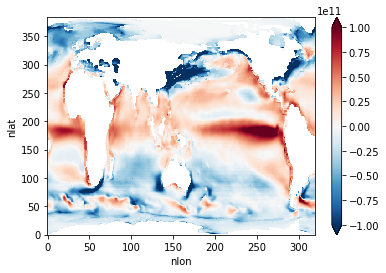

In [14]:
# total surface flux
temp_shf_tend = temp_qflux +  temp_senh_f + temp_lwdn_f + temp_lwup_f + \
    temp_melth_f + temp_shf_qsw + temp_evap_f + temp_snow_f + temp_ioff_f + temp_kpp_src
with ProgressBar():
    temp_shf_tend.isel(time=slice(0,11)).mean("time").plot(vmin=-1e11,vmax=1e11,cmap="RdBu_r")